# Pressure vessel analysis according to an ASME standard {#ref_ASME_SecVIII_Div2}

This example demonstrates how you can use PyDPF to postprocess a
Mechanical model according to the ASME Section VIII Division 2 standard
for pressure vessel designs.

This example is taken from Workshop 02.1 from Ansys Mechanical Advanced
Topics. Instead of using several user defined results as it is done in
the workshop, DPF is able to calculate the triaxial strain limit and
compare it with the equivalent plastic strain, as specified in Equation
5.7 assuming 0 forming strain.

Please be aware that this is just an example, so it is the user\'s duty
to verify that calculation is made according to latest ASME standard.


In [1]:
# Import the result file from Workshop 02.1.
# Because it is a elastic-plastic analysis, there are several substeps. The focus
# here is on the latest substep (number 4)

import ansys.dpf.core as dpf
from ansys.dpf.core import examples

path = examples.download_example_asme_result()
model = dpf.Model(path)
data_source = model.metadata.data_sources

time_scoping = dpf.Scoping()
time_scoping.location = dpf.locations.time_freq
time_scoping.ids = [4]

# Parameters input

You must go to ASME Section III Division 2 to get values for the
parameters `alfasl` and `m2`. This is the code for introducing these
parameters manually:

-   `alfasl` = input(\"Introduce `alfasl` parameter from ASMEn\")
-   `alfasl` = float(alfasl)
-   `m2` = input(\"Introduce `m2` parameter from ASMEn\")
-   `m2` = float(m2)

For this exercise, `alfasl` = 2.2 and `m2` = .288, which is the same as
the original.


In [2]:
alfasl = 2.2
m2 = 0.288

# Stresses and strains

Stresses and strains are read. To get the same results as Mechanical,
read elemental nodal strains and apply von Mises invariant. This
operator does not have an option for defining the effective Poisson\'s
ratio. Consequently, a correction factor is applied.


In [3]:
seqv_op = dpf.operators.result.stress_von_mises(
    time_scoping=time_scoping, data_sources=data_source, requested_location=dpf.locations.nodal
)
seqv = seqv_op.outputs.fields_container()

s1_op = dpf.operators.result.stress_principal_1(
    time_scoping=time_scoping, data_sources=data_source, requested_location=dpf.locations.nodal
)
s1 = s1_op.outputs.fields_container()

s2_op = dpf.operators.result.stress_principal_2(
    time_scoping=time_scoping, data_sources=data_source, requested_location=dpf.locations.nodal
)
s2 = s2_op.outputs.fields_container()

s3_op = dpf.operators.result.stress_principal_3(
    time_scoping=time_scoping, data_sources=data_source, requested_location=dpf.locations.nodal
)
s3 = s3_op.outputs.fields_container()

strain_op = dpf.operators.result.plastic_strain(
    data_sources=data_source,
    requested_location=dpf.locations.elemental_nodal,
    time_scoping=time_scoping,
)
pstrain = strain_op.outputs.fields_container()

eppleqv_op = dpf.operators.invariant.von_mises_eqv_fc(fields_container=pstrain)
eppleqv = eppleqv_op.outputs.fields_container()

poisson_ratio_correction = 1.3 / 1.5
eppleqvmech_op = dpf.operators.math.scale_fc(
    fields_container=eppleqv, ponderation=poisson_ratio_correction
)
eppleqvmech = eppleqvmech_op.outputs.fields_container()


eppleqvave_op = dpf.operators.averaging.to_nodal_fc(fields_container=eppleqvmech)
eppleqvave = eppleqvave_op.outputs.fields_container()

# Triaxial strain limit calculation


In [4]:
# S12=S1+S2
s12_op = dpf.operators.math.add_fc(fields_container1=s1, fields_container2=s2)
s12 = s12_op.outputs.fields_container()
# S123=S12+S3
s123_op = dpf.operators.math.add_fc(fields_container1=s12, fields_container2=s3)
s123 = s123_op.outputs.fields_container()
# SVM_scale=SVM*3
ratio = 3.0
seqvs_op = dpf.operators.math.scale_fc(fields_container=seqv, ponderation=ratio)
seqvs = seqvs_op.outputs.fields_container()
# S123/SVM*3
sratio_op = dpf.operators.math.component_wise_divide(fieldA=s123, fieldB=seqvs)
sratio = sratio_op.outputs.field()
# S123/SVM*3-0.33
sterm_op = dpf.operators.math.add_constant(field=sratio, ponderation=-1 / 3)
sterm = sterm_op.outputs.field()
# -alfasl/(1+m2)*stressterm
ratio2 = -alfasl / (1 + m2)
expt_op = dpf.operators.math.scale(field=sterm, ponderation=ratio2)
expt = expt_op.outputs.field()
# exp(-alfasl/(1+m2)*stressterm)
exp_op = dpf.operators.math.exponential(field=expt)
exp = exp_op.outputs.field()
# elu*exp(-alfasl/(1+m2)*stressterm)
strainlimit_op = dpf.operators.math.scale(field=exp, ponderation=m2)
strainlimit = strainlimit_op.outputs.field()

# Strain limit condition (less than 1 pass the criteria)


In [5]:
strainratio = dpf.operators.math.component_wise_divide(fieldA=eppleqvave, fieldB=strainlimit)
strainratio = strainratio.outputs.field()

# Strain limit condition is plot


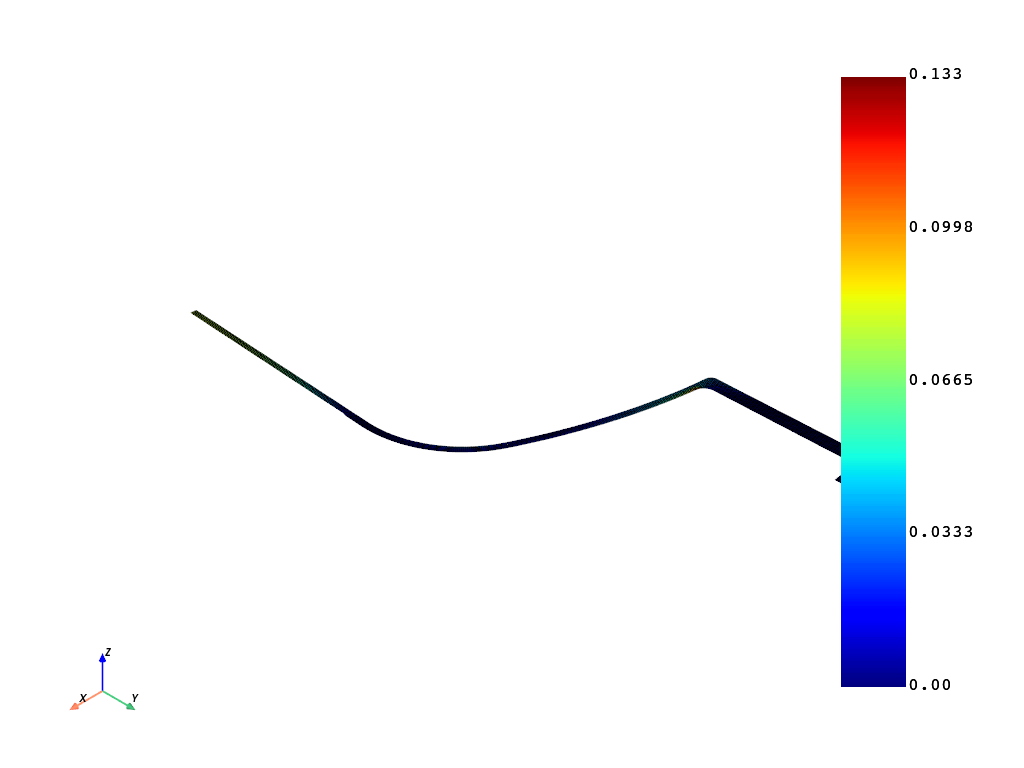

In [6]:
model.metadata.meshed_region.plot(strainratio)
dpf.server.shutdown_all_session_servers()